# Part II - Ford GoBike System Data
## by Dragos Ungureanu

## Investigation Overview


>The main point of interest is to find out the features that could predict what influences the bike stations' activities.

>This analysis allowed us to take a look at several characteristics of the bike stations and their customers. The key insights are:

- there are roughly three regions for both start and end stations. Moreover, we saw that these share the same geo location, therefore, a start location is also an end location;
- the top busiest end station is 0.52% busier than the second busiest end station;
- bike riders that ended at the busiest end station have not started from the same stations on the top 10 busiest start stations;
- customer user type will ride substantially longer than subcriber user type for both start and end stations.
- younger (around 20 years) users will take the longest rides and above 80 years old taking the shortest.
- on weekends are recorded the longest rides for both ages and user types;
- on weekends, younger members tend to ride longer.

## Dataset Overview

> This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area in February 2019.

> This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.

> After wrangling, the data to be analysed has 174,881 bike rides with 21 columns, of which 10 columns are numeric, 4 object, 2 datatime and 5 category.

>The duration column has only data of rides that are above 60 seconds.

In [75]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [76]:
# Load the data file
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [77]:
# Preliminary exploration with code
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
duration_sec               183412 non-null int64
start_time                 183412 non-null object
end_time                   183412 non-null object
start_station_id           183215 non-null float64
start_station_name         183215 non-null object
start_station_latitude     183412 non-null float64
start_station_longitude    183412 non-null float64
end_station_id             183215 non-null float64
end_station_name           183215 non-null object
end_station_latitude       183412 non-null float64
end_station_longitude      183412 non-null float64
bike_id                    183412 non-null int64
user_type                  183412 non-null object
member_birth_year          175147 non-null float64
member_gender              175147 non-null object
bike_share_for_all_trip    183412 non-null object
dtypes: float64(7), int64(2), object(7)
memory usage: 22.4+ MB
None


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [78]:
# Drop the rows with null data
df_clean = df.copy()
df_clean = df_clean.dropna(axis=0)
df_clean.reset_index(drop='index', inplace=True)
# Check for the null data left if any
print(f'The list of the columns with empty cells:\n{df_clean.isnull().sum()}')

The list of the columns with empty cells:
duration_sec               0
start_time                 0
end_time                   0
start_station_id           0
start_station_name         0
start_station_latitude     0
start_station_longitude    0
end_station_id             0
end_station_name           0
end_station_latitude       0
end_station_longitude      0
bike_id                    0
user_type                  0
member_birth_year          0
member_gender              0
bike_share_for_all_trip    0
dtype: int64


In [79]:
# Check the start and end number of stations with unique ids
print(f'Number of start stations: \n{df_clean.start_station_id.nunique()}\nNumber of end stations:\n{df_clean.end_station_id.nunique()}')

Number of start stations: 
329
Number of end stations:
329


In [80]:
# Change the date format
df_clean.start_time = pd.to_datetime(df_clean.start_time,utc=True)
df_clean.end_time = pd.to_datetime(df_clean.end_time,utc=True)

# Check the format of start and end times
print(f'The format of the start time is {df_clean.start_time.dtype} and the end time is {df_clean.end_time.dtype}.')

The format of the start time is datetime64[ns, UTC] and the end time is datetime64[ns, UTC].


In [81]:
# Add a new column with the days of the week
df_clean['start_weekday'] = df_clean['start_time'].dt.day_name()
df_clean['end_weekday'] = df_clean['end_time'].dt.day_name()

In [82]:
# Change the data type of the day of the week columns
weekday_start_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_start_cat = pd.api.types.CategoricalDtype(ordered = True, categories = weekday_start_list)
df_clean['start_weekday'] = df_clean['start_weekday'].astype(weekday_start_cat)

weekday_end_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_end_cat = pd.api.types.CategoricalDtype(ordered = True, categories = weekday_end_list)
df_clean['end_weekday'] = df_clean['end_weekday'].astype(weekday_end_cat)

In [83]:
# Change the datat types for the gender column
gender_list = ['Male', 'Female', 'Other']
gender_cat = pd.api.types.CategoricalDtype(ordered = True, categories = gender_list)
df_clean['member_gender'] = df_clean['member_gender'].astype(gender_cat)

In [84]:
# Check for 0 sec of duration 
df[df.duration_sec == 0]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip


In [85]:
# Creat two new columns with new parts of the day categories
bins = [0,4,11,16,20,23]
labels = ['Late Night','Morning','Afternoon','Evening','Night']
df_clean['start_day_parts'] = pd.cut(df_clean['start_time'].dt.hour, bins=bins, labels=labels, include_lowest=True)
df_clean['end_day_parts'] = pd.cut(df_clean['end_time'].dt.hour, bins=bins, labels=labels, include_lowest=True)

start_day_parts_cat = pd.api.types.CategoricalDtype(ordered = True, categories = labels)
df_clean['start_day_parts'] = df_clean['start_day_parts'].astype(start_day_parts_cat)

end_day_parts_cat = pd.api.types.CategoricalDtype(ordered = True, categories = labels)
df_clean['end_day_parts'] = df_clean['end_day_parts'].astype(end_day_parts_cat)

In [86]:
# Add a new age column 
df_clean['member_birth_year'] = df_clean.member_birth_year.astype(int)
df_clean['age'] = 2022 - df_clean['member_birth_year']

Next, we will drop the rows of people with age higher than 114. As of 28 July 2022, it lists the oldest living American-born person as Spanish emigrant María Brañas Morera (born in San Francisco, California on March 4, 1907), aged 115 years, 146 days. More infor can be accessed via [this link](https://en.wikipedia.org/wiki/List_of_American_supercentenarians#:~:text=As%20of%2027%20July%202022,aged%20115%20years%2C%20145%20days.).

In [87]:
# Drop the rows with age above 100 years
index_above114 = df_clean.query('age > 114').index
df_clean.drop(axis=0, index=index_above114, inplace=True)

In [88]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174881 entries, 0 to 174951
Data columns (total 21 columns):
duration_sec               174881 non-null int64
start_time                 174881 non-null datetime64[ns, UTC]
end_time                   174881 non-null datetime64[ns, UTC]
start_station_id           174881 non-null float64
start_station_name         174881 non-null object
start_station_latitude     174881 non-null float64
start_station_longitude    174881 non-null float64
end_station_id             174881 non-null float64
end_station_name           174881 non-null object
end_station_latitude       174881 non-null float64
end_station_longitude      174881 non-null float64
bike_id                    174881 non-null int64
user_type                  174881 non-null object
member_birth_year          174881 non-null int64
member_gender              174881 non-null category
bike_share_for_all_trip    174881 non-null object
start_weekday              174881 non-null category
end_we

## 1. The busiest bike stations

> Here we can see the busiest 10 start and end stations. This could be extremely helpful information for the bike stations, in order to properly prioritise the busiest stations to bring more bikes (for the start station) and from where to constantly take the left bikes (end stations).

>The sub-slide reveals to us that the bikes taken from the busiest starting station prefer to leave most of the bikes at Montgomery St BART station. Since this station is a top 10 busiest end stations, the risk of having it overwhelmed is low. Nonetheless, we can see that there is one more station which might have been missed as it is not in the top 10 busiest end stations, namely Civic Center/UN Plaza with around 150 bikes. However, this might not be a problem for this particular station. 

>On the contrary, the bikes left at the busiest end stations show that the prefered start station Market St at 10th St is the only one that is on the list of the top 10 busiest start stations. This information could help the team keep in mind the capacity of these stations and provide the needed amount of bikes.

In [89]:
# Defining a function to make the code easier to read
def plotFunction(title, xLabel, yLabel):
    """This will return the name of the title, xlabel and ylabel"""
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)

## Univariate Exploration

### What is the average time the bikes are shared?

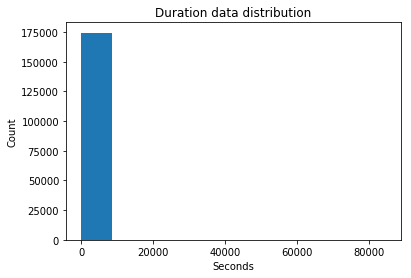

In [90]:
# Explore the spread of duration data
plt.hist(data = df_clean, x = 'duration_sec')

plotFunction('Duration data distribution', 'Seconds', 'Count')

Data of the duration expressed in seconds is skewed to the right with far-reaching outaliers. 

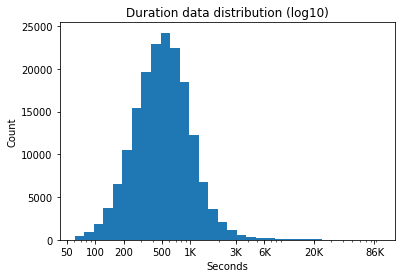

In [91]:
# Transform the data to a log scale 
bins = 10 ** np.arange(np.log10(df.duration_sec.min()),
                       np.log10(df.duration_sec.max()) + 0.1, 
                       0.1)
ticks = [50, 100, 200, 500, 1000, 3000, 6000, 20000, 86000]

plt.hist(data=df_clean, x = 'duration_sec', bins=bins)
plt.xscale('log')

plt.xticks(ticks, ['50', '100', '200', '500', '1K', '3K', '6K', '20K', '86K'])
plotFunction('Duration data distribution (log10)', 'Seconds', 'Count')

When plotted on a log-scale, the duration distribution looks clearly unimodal, with the peak at 500. Interestingly, there's a smooth build up in frequency that leads to 500 seconds, continuing to expand up to around 86k seconds, which represents almost 24 hours. We could think that such a steep rise of outliers could represent erroneous data. However, further sorting of the duration_sec column reveals several instances of sharing the bike for long hours.

In [92]:
# Sort the duration values to check the outliers
df_clean.duration_sec.sort_values(ascending=False)[:15]

81604     84548
122163    83519
107291    83407
4987      83195
91253     82512
8291      81549
102616    79548
85962     74408
82496     74097
117808    73930
123264    72627
111379    72590
123265    72576
139250    71470
28804     70925
Name: duration_sec, dtype: int64

### What is the relationship between data on longitude and latitude of the start and end stations?

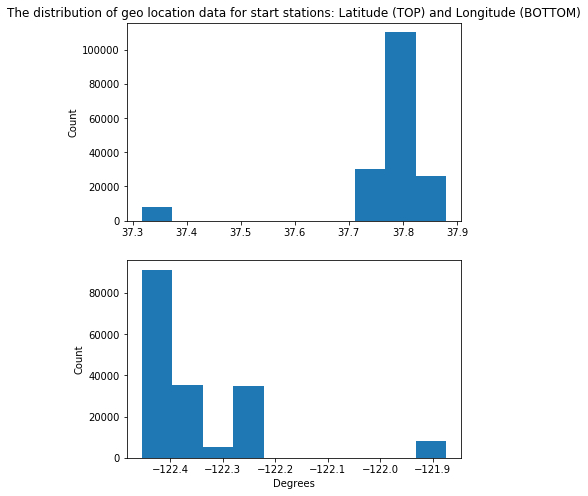

In [93]:
# Preliminary exploration of the start stations' geo location data
plt.figure(figsize = (6, 8))

# subplot 1: start station latitude data
plt.subplot(2, 1, 1)
plt.hist(data = df_clean, x = 'start_station_latitude')

plotFunction('The distribution of geo location data for start stations: Latitude (TOP) and Longitude (BOTTOM)',
             '', 'Count')

# subplot 2: start station longitude data
plt.subplot(2, 1, 2)
plt.hist(data = df_clean, x = 'start_station_longitude')

plotFunction('', 'Degrees', 'Count') 

To have a better representation of the data, we need to further bin the data.

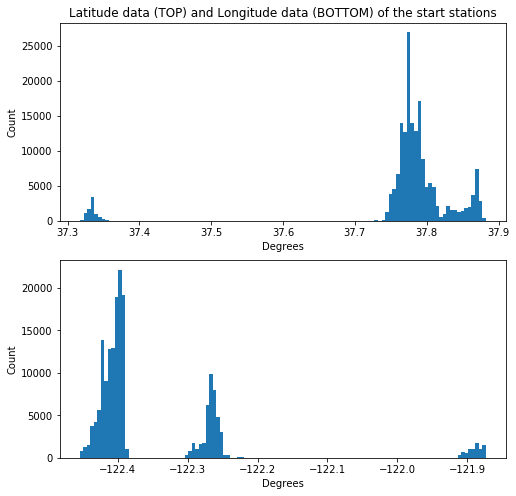

In [94]:
# Further exploring the latitudine and longitude of the start stations

# binning the latitude data
bins_lat = np.arange(df_clean.start_station_latitude.min(),
                     df_clean.start_station_latitude.max()+0.005,
                     0.005)

# binning the longitude data
bins_long = np.arange(df_clean.start_station_longitude.min(),
                     df_clean.start_station_longitude.max()+0.005,
                     0.005)


plt.figure(figsize = (8,8))

# subplot 1: start station latitude data
plt.subplot(2, 1, 1)
plt.hist(data = df_clean, x = 'start_station_latitude', bins = bins_lat)

plotFunction('Latitude data (TOP) and Longitude data (BOTTOM) of the start stations',
             'Degrees', 'Count')

# subplot 2: start station longitude data
plt.subplot(2, 1, 2)
plt.hist(data = df_clean, x = 'start_station_longitude', bins = bins_long)

plotFunction('', 'Degrees', 'Count')

There are three spikes of different frequency, with the most frequent between 37.7 and 37.8 degrees of latitude and 122.4 degrees longitude. At this point it is worth exploring the end stations as well.

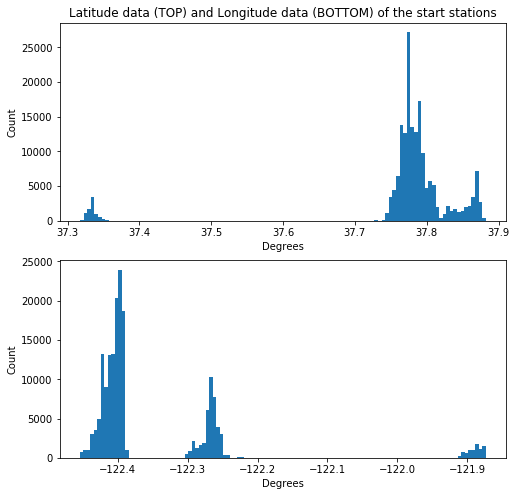

In [95]:
# Further exploring the latitudine and longitude of the end stations

# binning the lattitude data
bins_lat_end = np.arange(df_clean.end_station_latitude.min(),
                     df_clean.end_station_latitude.max()+0.005,
                     0.005)

# binning the longitude data
bins_long_end = np.arange(df_clean.end_station_longitude.min(),
                     df_clean.end_station_longitude.max()+0.005,
                     0.005)


plt.figure(figsize = (8,8))

# subplot 1: end station latitude data
plt.subplot(2, 1, 1)
plt.hist(data = df_clean, x = 'end_station_latitude', bins = bins_lat_end)

plotFunction('Latitude data (TOP) and Longitude data (BOTTOM) of the start stations',
             'Degrees', 'Count')

# subplot 2: end station longitude data
plt.subplot(2, 1, 2)
plt.hist(data = df_clean, x = 'end_station_longitude', bins = bins_long_end)

plotFunction('', 'Degrees', 'Count')

At this point, we can observe that the start and end locations are roughly the same. To double-check this, a bivariate representation of both the start and end points would be produced in the next section.

### What are the busiest bike stations and what these can reveal about other less busy stations?

In [96]:
# Group the data on location name
start_count = df_clean.groupby('start_station_name', as_index=False)['bike_id'].count().sort_values('bike_id', ascending = False)
end_count = df_clean.groupby('end_station_name', as_index=False)['bike_id'].count().sort_values('bike_id', ascending = False)

In [97]:
# Assign counts of values to be iterated
bike_start_counts = df_clean['start_station_name'].value_counts()
bike_end_counts = df_clean['end_station_name'].value_counts()

In [98]:
# Returns the sum of all value counts of the bikes
n_bikes_start = bike_start_counts.sum()
n_bikes_end = bike_end_counts.sum()

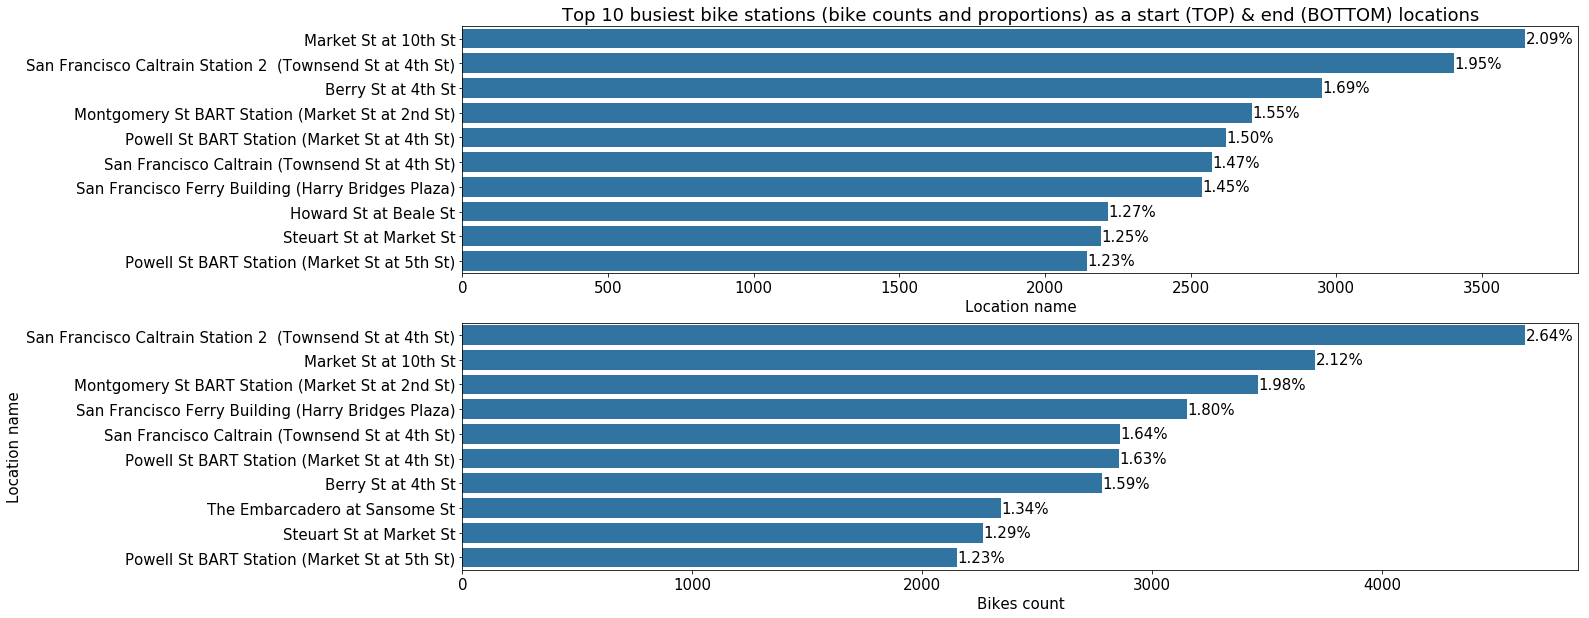

In [99]:
# Plot the Top 10 busiest location for bike start and end locations
base_color = sb.color_palette()[0]

plt.figure(figsize=(20,10))
plt.rcParams['font.size'] = '15'

# subplot 1: 10 most busiest start stations
plt.subplot(2,1,1)
sb.barplot(x = start_count.bike_id.iloc[:10], y = start_count.start_station_name.iloc[:10],
           color = base_color);

# print the proportion text on the bars for subplot 1
for i in range (10):
    count = bike_start_counts[i]
    # Convert count into a percentage, and then into string
    pct_string = '{:0.2f}%'.format(100*count/n_bikes_start)
    # Print the string value on the bar. 
    plt.text(count+1, i, pct_string, va='center')

plotFunction('Top 10 busiest bike stations (bike counts and proportions) as a start (TOP) & end (BOTTOM) locations',
             'Location name', '')

# subplot 2: 10 most busiest end stations
plt.subplot(2,1,2)
sb.barplot(x = end_count.bike_id.iloc[:10], y = end_count.end_station_name.iloc[:10],
           color = base_color);

# print the proportion text on the bars for subplot 2
for i in range (10):
    count = bike_end_counts[i]
    # Convert count into a percentage, and then into string
    pct_string = '{:0.2f}%'.format(100*count/n_bikes_end)
    # Print the string value on the bar. 
    plt.text(count+1, i, pct_string, va='center')

plotFunction('', 'Bikes count', 'Location name')

The above charts show us the busiest 10 start and end stations. This could be extremely helpful information for the bike stations, in order to properly prioritise the busiest stations to bring more bikes (for the start station) and from where to constantly take the left bikes (end stations).

To get further insight, we need to take a look at what stations are preferred by the bike riders from the busiest start and end stations.

In [100]:
# Group the data
start_end_st = df_clean[df_clean['start_station_name'] == "Market St at 10th St"].groupby('end_station_name', as_index = False)['bike_id'].count().sort_values('bike_id', ascending = False)
start_end_st = start_end_st.reset_index(drop = 'index')

end_start_st = df_clean[df_clean['end_station_name'] == end_count.iloc[0][0]].groupby('start_station_name', as_index = False)['bike_id'].count().sort_values('bike_id', ascending = False)
end_start_st = end_start_st.reset_index(drop = 'index')

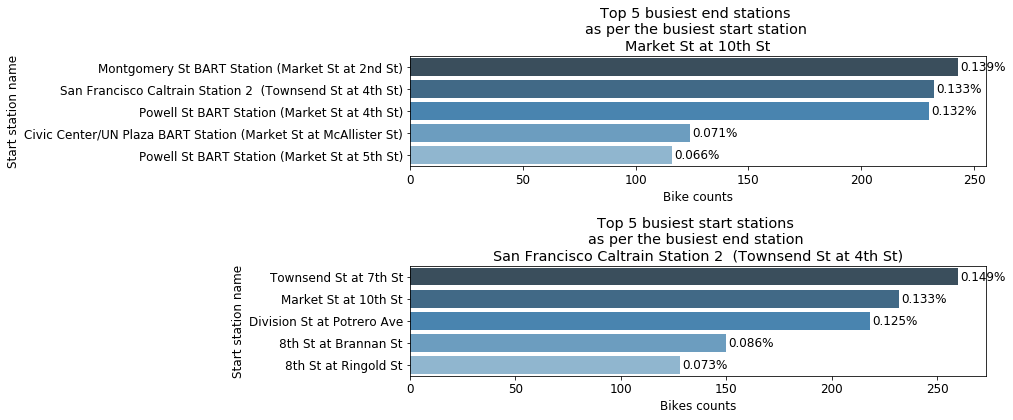

In [101]:
# Plot the Top 5 busiest location for most busiest bike start and end locations
plt.figure(figsize = (14, 6))
plt.rcParams['font.size'] = '12'

# subplot 1: end stations for the busiest start station
plt.subplot(2, 1, 1)
sb.barplot(x = start_end_st.bike_id.iloc[:5], y = start_end_st.end_station_name.iloc[:5],
           palette="Blues_d")

# print the proportion text on the bars for subplot 1
for i in range (5):
    count = start_end_st.bike_id[i]
    # Convert count into a percentage, and then into string
    pct_string = '{:0.3f}%'.format(100*count/n_bikes_end)
    # Print the string value on the bar. 
    plt.text(count+1, i, pct_string, va='center')

plotFunction('Top 5 busiest end stations \nas per the busiest start station \nMarket St at 10th St',
             'Bike counts', 'Start station name')

# subplot 2: start station for busiest end station
plt.subplot(2, 1, 2)
sb.barplot(x = end_start_st.bike_id.iloc[:5], y = end_start_st.start_station_name.iloc[:5],
           palette="Blues_d");

# print the proportion text on the bars for subplot 2
for i in range (5):
    count = end_start_st.bike_id[i]
    # Convert count into a percentage, and then into string
    pct_string = '{:0.3f}%'.format(100*count/n_bikes_end)
    # Print the string value on the bar. 
    plt.text(count+1, i, pct_string, va='center')

plotFunction(f'Top 5 busiest start stations \nas per the busiest end station \n{end_count.iloc[0][0]}',
             'Bikes counts', 'Start station name')
plt.tight_layout()

The above reveals to us that the bikes taken from the busiest starting station prefer to leave most of the bikes at Montgomery St BART station. Luckily this station is top 10 busiest end stations and therefore, the risk of having it overwhelmed is low. Nonetheless, we can see that there is one more station which might have been missed as it is not in the top 10 busiest end stations, namely Civic Center/UN Plaza with around 150 bikes. However, this might not be a problem for this particular station. Nonetheless, keeping it in mind might be beneficial at times.

On the contrary, the bikes left at the busiest end stations show that the prefered start station Market St at 10th St is the only one that is on the list of the top 10 busiest start stations. This information could help the team keep in mind the capacity of these stations and supply these stations with the needed amount of bikes.

## 2. The relation between geo location data of start and end stations

>As we can see the geo locations of the start and end stations are roughly the same, therefore, we can confidently say that the start locations fulfil the function of the end location as well. There are roughly three regions for both start and end locations. Please note that although the difference between these groups of geo locations is only a couple of digits, 0.1 degrees represent 11.1 km.

### What is the male to female bike riders ratio?

In this next section we will explore the ratio between gender categories to better understand the preferences based on gender.

In [102]:
# Produce the max proportion variable
gen_counts = df_clean['member_gender'].value_counts()
n_gen = gen_counts.sum()
max_gen_count = gen_counts[0]
gen_order = gen_counts.index

max_prop = max_gen_count / n_gen
print(max_prop)

0.745895780559


In [103]:
# Produce a set of evenly spaced proportioned values between 0 and max_prop, with a step size 2%
tick_props = np.arange(0, max_prop, 0.02)

# Create tick_names that we will apply to the tick labels. 
# Each element `v` from the `tick_props` will be converted into a formatted string.
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

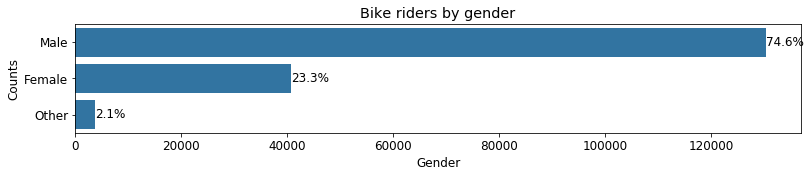

In [104]:
# Explore bikeriding by gender
plt.figure(figsize = (13, 2))

sb.countplot(data = df_clean, y = 'member_gender', 
             color=base_color, order=gen_order)

# print the proportion text on the bars
for i in range (gen_counts.shape[0]):
    count = gen_counts[i]
    # Convert count into a percentage, and then into string
    pct_string = '{:0.1f}%'.format(100*count/n_gen)
    # Print the string value on the bar. 
    plt.text(count+1, i, pct_string, va='center')

plotFunction('Bike riders by gender', 'Gender', 'Counts')

As we can see, the majority of bike riders are in the male gender category with alomst 75% of bike riders. Next are female gender category with more than 23% and other gender category with more than 2%.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> In order to better understand the distribution of data, logarithmic scale transformation was needed. This helped alleviate the distance between the main data and the outliers, who proved to be valid data. In turn, this allowed us to see a better picture of the distribution of data and what geo locations had the most information available.

>About the busiest stations, we needed to group the data to catch the busiest stations and then calculate the overall percentage for a better representation. The same goes for the gender category data.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> As previously mentioned, several outliers have been identified when analysing the geo location of the bike stations. However, these proved to be valid data as the records show a gradual decrease of duration from its highest value which is below 24 hours.

> Also, as we will see below, these high duration values do not alter the mean values, as these are part of bike stations' experience with customers.

## Bivariate Exploration

### How does the geo location data of start and end stations relate?

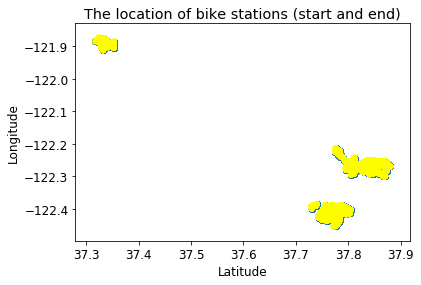

In [105]:
# Bivariate representation of the start and end locations 
# regplot 1.1: geo location of the start stations (blue)
sb.regplot(data=df_clean, x='start_station_latitude', y='start_station_longitude', color=base_color, fit_reg=False)

# regplot 1.2: geo location of the end stations (yellow)
sb.regplot(data=df_clean, x='end_station_latitude', y='end_station_longitude', color='yellow', 
           scatter_kws={'alpha':0.4, 'linewidths':-5, 'edgecolors':'none'}, fit_reg=False)

plotFunction('The location of bike stations (start and end)', 'Latitude', 'Longitude')
plt.legend()

As we can see the geo locations of the start and end stations are roughly the same, therefore, we can confidently say that the start locations fulfil the function of the end location as well. There are roughly three regions for both start and end locations. Please note that although the difference between these groups of geo locations is only a couple of digits, 0.1 degrees represent 11.1 km.

### What are the busiest days of the week based on gender?

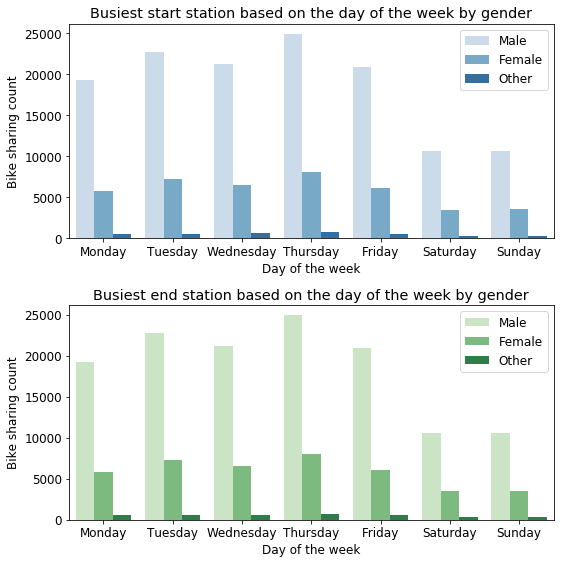

In [106]:
# since there are only three subplots to create, using the full data should be fine.
plt.figure(figsize = [8, 8])

# subplot 1: 
ax = plt.subplot(2, 1, 1)
sb.countplot(data = df_clean, x = 'start_weekday', hue = 'member_gender', palette = 'Blues')

plotFunction('Busiest start station based on the day of the week by gender',
             'Day of the week', 'Bike sharing count')

ax.legend(ncol = 1) # re-arrange legend to reduce overlapping

# subplot 2: 
ax = plt.subplot(2, 1, 2)
sb.countplot(data = df_clean, x = 'end_weekday', hue = 'member_gender', palette = 'Greens')

plotFunction('Busiest end station based on the day of the week by gender',
             'Day of the week', 'Bike sharing count')

ax.legend(ncol = 1); # re-arrange legend to reduce overlapping
plt.tight_layout()

At this point, it is relevant to mention that Thursday is the busiest day for all three gender categories.

Further, it will be interesting to explore what part of the busiest day (Thursday) is the busiest based on three gender categories.

### What part of Thursday is the busiest based upon the three gender categroies?

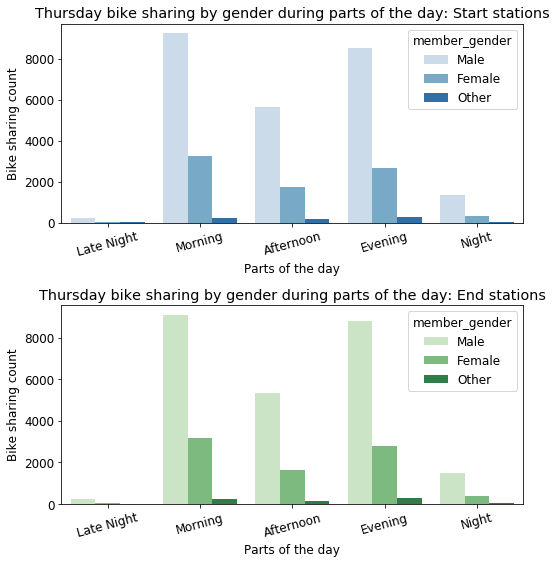

In [107]:
# Filtering the rows of Thursday data 
thursdays_start = df_clean.loc[df_clean['start_weekday'].isin(['Thursday'])]
thursdays_end = df_clean.loc[df_clean['end_weekday'].isin(['Thursday'])]

# plotting 
plt.figure(figsize = (8, 8))

# subplot 1: start station data
plt.subplot(2, 1, 1)
sb.countplot(data = thursdays_start, x = 'start_day_parts', hue = 'member_gender',
            palette = "Blues")
ax.legend(loc = 0)

plt.xticks(rotation = 15)
plotFunction('Thursday bike sharing by gender during parts of the day: Start stations',
            'Parts of the day', 'Bike sharing count')

# subplot 2: start station data
plt.subplot(2, 1, 2)
sb.countplot(data = thursdays_end, x = 'end_day_parts', hue = 'member_gender',
                 palette = 'Greens')
ax.legend(loc = 0)
plt.xticks(rotation = 15)
plotFunction('Thursday bike sharing by gender during parts of the day: End stations',
             'Parts of the day', 'Bike sharing count')

plt.tight_layout();

The busiest parts of the busiest day (Thursday) are mornings and evenings.

In the morning the highest bike count is for males and females. However, the other gender category uses the bikes on Thursday evenings. 

The second busiest part of the day, evenings, are the only second busiest part of Thursday for males and females whilst it is the busiest for other gender category.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> We observed that the busiest day of the week is Thursday for all three gender categories males, females and other. Also, we saw that for male and female gender categories Thursday mornings are the busiest, whilst for the other gender category Thursday evenings are the busiest.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> We discovered that the geo locations of both start and end stations are roughly the same. This relationship reveals that the start and end stations are grouped in three distinct regions. This helps us better understand that a start location might be also an end location. Therefore, a balance can be achieved by looking at the flux and influx of bikes. 

## Multivariate Exploration

### What is the relationship between numeric data (age, duration) and categorical data (user type, weekdays)?

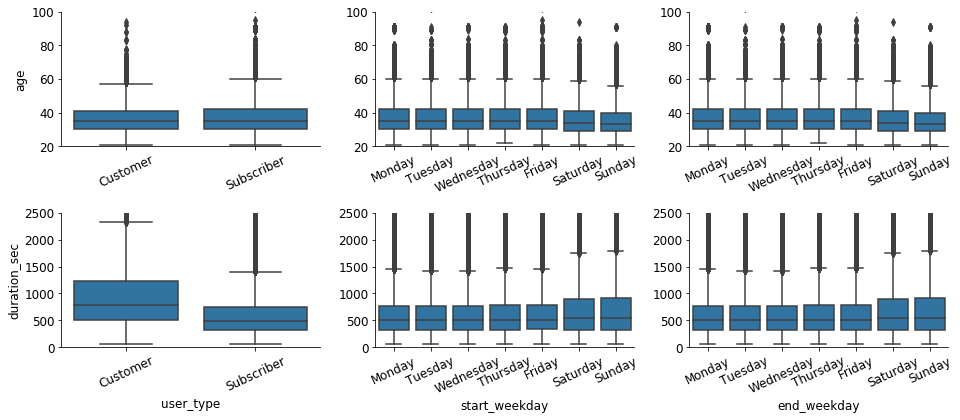

In [108]:
# Plot matrix of numeric features against categorical features.

numeric_vars = ['age', 'duration_sec']
categoric_vars = ['user_type', 'start_weekday', 'end_weekday']

samples = np.random.choice(df_clean.shape[0], 50000, replace = False)
df_samp = df_clean.iloc[samples,:]

def boxgrid(x, y, **kwargs):
    """ Creating box plots with seaborn's PairGrid."""
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)
    plt.xticks(rotation = 25)
    plt.tight_layout();

plt.figure(figsize = [10, 12])
g = sb.PairGrid(data = df_clean, y_vars = numeric_vars, x_vars = categoric_vars,
                size = 3, aspect = 1.5)
g.axes[0,0].set_ylim(20,100) # limit the age group for a better represenation
g.axes[1,0].set_ylim(0,2500) # limit the duration group to reduce the outliers


plt.xticks(rotation = 17)
g.map(boxgrid);
plt.tight_layout()

plt.show();


The user type data seems to be constant for the age groups with a slightly higher number of subscribers. Age also seems to be similar across the weekdays with slightly younger members riding on weekends.

On the other hand, the duration is a good predictor of user type 'customer', and namely high duration is associated with customer type membership. Also, in terms of ride duration during weekdays, it is constant with the mean amount of seconds at 500. However, during the weekends we can observe the duration of rides increase.

Further, it will be relevant to explore the relationship between duration on one side and age and user type on the other.

## 3. The average duration of bike riding by age and user types

>Interestingly, we can observe a difference in behaviour between user types. Whilst the customers will vary based on age with a steep increase in the duration of rides above 60 and a decrease after around 80 years, the subscribers are more linear up to above 80 years old. Also, at around 21 years of age both types of users will ride for the same mean amount of around 2,500 seconds.

>If for the customers the duration ranges between 1,000 and around 1,800 seconds the situation is roughly different for subscribers i.e. around 600 and up to 800 seconds. The decrease is even steeper for subscribers above 80 years old with the duration mean as low as 200 seconds only.

### What is the average duration of bike riding by age and user types?

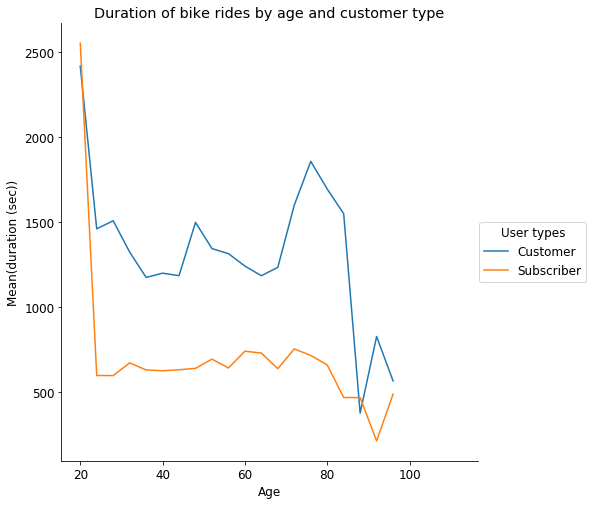

In [109]:
# Define a function to adapt the line plot
def mean_poly(x, y, bins = 10, **kwargs):
    """ Custom adapted line plot code. """
    # set bin edges if none or int specified
    if type(bins) == int:
        bins = np.linspace(x.min(), x.max()+1, bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # compute counts
    data_bins = pd.cut(x, bins, right = False,
                       include_lowest = True)
    means = y.groupby(data_bins).mean()

    # create plot
    plt.errorbar(x = bin_centers, y = means, **kwargs)

# Plot the data
bin_edges = np.arange(10, df_clean['age'].max()+4, 4)
g = sb.FacetGrid(data = df_clean, hue = 'user_type', size = 7)
g.map(mean_poly, "age", "duration_sec", bins = bin_edges)

plotFunction('Duration of bike rides by age and customer type',
             'Age', 'Mean(duration (sec))')

g.add_legend(title = 'User types');

Interestingly, we can observe a difference in behaviour between user types. Whilst the customers will vary based on age with a steep increase in the duration of rides above 60 and a decrease after around 80 years, the subscribers are more linear up to above 80 years old. Also, at around 21 years of age both types of users will ride for the same mean amount of around 2,500 seconds.

If for the customers the duration ranges between 1,000 and around 1,800 seconds the situation is roughly different for subscribers i.e. around 600 and up to 800 seconds. The decrease is even steeper for subscribers above 80 years old with the duration mean as low as 200 seconds only.

## 4. The average duration of bike riding by day of the week and user types

>We can see that the weekends (both Saturday and Sunday) have the average longest rides for both customers and subscribers for start stations.

>Also it is relevant mentioning that customers prefer to ride longer on Sundays whilst the subscribers prefer to ride more on Saturdays.

>The situation stays the same for the end stations with the exception of Wednesday, which sees a lower bike ride duration.

### What is the average duration of bike riding by day of the week and user types?

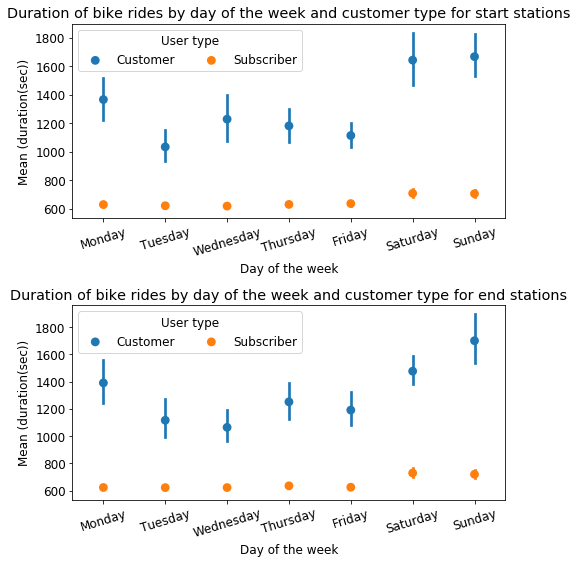

In [110]:
# Plot the data
plt.figure(figsize = (8, 8))

# subplot 1: days of the week vs duration by user type for start stations
plt.subplot(2,1,1)
ax = sb.pointplot(data = df_clean, x = 'start_weekday', y = 'duration_sec', hue = 'user_type',
                   linestyles = "")

plt.xticks(rotation = 17)
plt.title('Duration of bike rides by day of the week and customer type for start stations')
plt.xlabel('Day of the week')
plt.ylabel('Mean (duration(sec))')

plt.legend(title = 'User type', ncol = 2);

# subplot 2: days of the week vs duration by user type for end stations
plt.subplot(2, 1, 2)
ax = sb.pointplot(data = df_clean, x = 'end_weekday', y = 'duration_sec', hue = 'user_type',
                   linestyles = "")

plt.xticks(rotation = 17)
plotFunction('Duration of bike rides by day of the week and customer type for end stations',
             'Day of the week', 'Mean (duration(sec))')

plt.legend(title = 'User type', ncol = 2)
plt.tight_layout()

As we saw earlier, the data showed that the busiest day of the week was Thursday. Now, we can see that the weekends (both Saturday and Sunday) have the average longest rides for both customers and subscribers for start stations.

Also it is relevant mentioning that customers prefer to ride longer on Sundays whilst the subscribers prefer to ride more on Saturdays.

The situation stays the same for the end stations with the exception of Wednesday, which sees a lower bike ride duration.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Surprisingly, the customers (temporary pass up to 3 days) are the ones who are rinding longer than the subscribers (annual member) with the exception of members between 21-25 years and 86 years. Since customers are the ones that will constantly buy passes it is important to expect a higher counter activity to meet the demand for temporary passes. Also, an online purchase system could be employed if one is not present.

### Were there any interesting or surprising interactions between features?

> Although, customers with temporary passes are riding longer on any given day of the week, surprisingly the longest rides are during the weekends. The latter is a surprise because as we saw earlier, the busiest day is Thursday and on would expect to see the longest rides on Thursday as well. However, this is not the case and we can confidently say that on Thursday during mornings and evenings the flux of customers is the greatest and keeping an eye on the availability of bikes is important as well as keeping an on empty spaces for those who will leave their bikes.

## Conclusions
>This analysis allowed us to take a look at several characteristics of the bike stations and their customers. We saw that there are roughly three regions for both start and end stations. Moreover, we saw that these share the same geo location, therefore, a start location is also an end location.

>In terms of the busiest start stations there are no high differences between the stations with only 0.25%, whilst the top end station is 0.52% busier than the second busiest end station. On top of that, riders that start from the busiest station will end in the top 10 busiest end stations except for only one station, whilst the riders that ended at the busiest end station have not started from the same stations on the top 10 busiest start stations except only one. Therefore, the start station of the riders ending up at the busiest end stations requires more attention than the end stations of the riders coming from the busiest start stations as these are already taken into account by the top 10 busiest stations.

>Further, we saw that the busiest day of the week is Thursday. Also, the busiest parts of a Thursday are mornings and evenings. 

>Males is the most frequent gender category riding a bike at the San Francisco bike stations representing almost 75% of all the riders. The high ratio is also kept across all days of the week and all parts of the day.

>User type is one factor that will predict the duration of rides for both start and end stations, with customers riding substantially longer.

>Age is also a good predictor of duration with younger (around 20 years) users taking the longest rides and above 80 years old taking the shortest. However, in terms of user type, age is roughly equally distributed.

>On weekends are recorded the longest rides for both ages and user types. Also, on weekends, younger members tend to ride for a longer duration.

In [112]:
!jupyter nbconvert Part_II_slide_deck_Dragos_Ungureanu.ipynb --to slides --template output_toggle.tpl --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_slide_deck_Dragos_Ungureanu.ipynb to slides
[NbConvertApp] Writing 647586 bytes to Part_II_slide_deck_Dragos_Ungureanu.slides.html
